# Ambiente

In [ ]:
!pip install dask

In [ ]:
!pip install keras==2.12.0

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
pip install dask_ml

In [ ]:
# Configuração para exibir todas as colunas no dataframe
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dtype_dict = {
    'MATRICULA': 'object',
    'REFERENCIA': 'datetime',
    'CONSUMO_MEDIDO': 'float32',
    'VOLUME_ESTIMADO': 'float32',
    'VOLUME_ESTIMADO_ACUM': 'float32',
    'FATURADO_MEDIA': 'object'
}
data_consumo_fraude = dd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_BCB.parquet', dtype=dtype_dict)

In [ ]:
# Dados de Temperatura
temp = dd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/temperatura_campogrande.parquet')

# Dados Metereológicos

Ajustamos a coluna 'ANOMES', que está sendo convertida para o formato correto e para o tipo categórico. Isso corrige problemas que ocorriam com o formato antigo dessa coluna.

In [ ]:
df = data_consumo_fraude
df = df.drop(columns=['anomes'])
df['ANOMES'] = df['ANOMES'].astype('category')
df = df.categorize(columns=['ANOMES'])

Transformação do formato da coluna 'ANOMES' de um formato "AAAA/MM" para o formato "MM/AAAA". Além disso, é aplicada uma função que faz mais ajustes de formato caso haja inconsistências.

In [ ]:
# Transformar Ano_Mes em 06/21
temp['ANOMES'] = temp['Ano_Mes'].astype(str)
temp['ANOMES'] = temp['ANOMES'].str[-2:] + '/' + temp['ANOMES'].str[:4]
def convert_date(x):
    if pd.isna(x):
        return x
    # Converter para string no formato 'MM/AAAA'
    x_str = x.strftime('%m/%Y')
    # Aplicar slicing para obter o formato 'MM/AA'
    return x_str[:3] + x_str[-2:]

# Aplicando a função com apply e especificando o tipo de dado esperado (meta)
temp['ANOMES'] = temp['Ano_Mes'].apply(convert_date, meta=('ANOMES', 'object'))

# Computando o resultado
df_result = temp.compute()

Junção entre os dados de consumo 'df' e os dados meteorológicos 'df_result' com base na coluna ANOMES. Após a junção, o DataFrame final é computado para aplicar as transformações.

In [ ]:
df = df.merge(df_result, on='ANOMES', how='left')
df.compute()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,valor_anterior_IGPM,valor_SELIC,valor_anterior_SELIC,valor_IPCA,valor_anterior_IPCA,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,4.10,0.014635,0.014498,0.53,0.83,2021-06-01,21.670000,8.743333,151.866667,22,8,0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,-0.64,0.024244,0.023965,1.25,1.16,2021-10-01,26.712903,10.319355,182.935484,19,10,2
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762969,2021-02-01,17582391,1039300.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.516003,-54.668869,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
762970,2021-03-01,1736441,177835.0,30.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,10.0,10.0,MEDIA,Normal,-20.491239,-54.631760,03/21,<NA>,0,2.53,0.008734,0.008608,0.93,0.86,2021-03-01,25.487097,5.058065,136.000000,23,8,0
762971,2021-02-01,1782928,334340.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.464472,-54.521082,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
762972,2021-02-01,17730829,1065042.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.528720,-54.636929,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0


# Dados Shows

Fizemos um web scraping de todos os shows que tiveram em Campo Grande, separados por 'Ano_Mes'. Depois fizemos o label enconding dos artistas e o número de shows que eles performaram cada mês.

A função 'extract_info' faz a requisição para o site e extrai a data e o artista de cada show da página de eventos de Campo Grande.

A função 'scrape_all_pages' faz o scraping de múltiplas páginas, onde os dados extraídos de cada página são concatenados em um único DataFrame. Ela continua até não haver mais dados em novas páginas.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Função para extrair os shows de uma página
def extract_shows_from_page(page_number):
    # Atualizar o link para incluir o número da página
    link = f'https://www.setlist.fm/search?page={page_number}&country=br&query=Campo+Grande+'

    # Fazer a requisição
    response = requests.get(link)

    # Criar o objeto BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Encontrar todos os blocos que contêm as informações dos shows
    shows = soup.find_all('div', class_='col-xs-12 setlistPreview')

    # Lista para armazenar os dados da página
    data = []

    # Iterar sobre todos os shows e extrair as datas e o artista
    for show in shows:
        # Extrair a data (mês, dia e ano)
        month = show.find('span', class_='month').text
        day = show.find('span', class_='day').text
        year = show.find('span', class_='year').text
        date = f"{month} {day}, {year}"

        # Extrair o artista
        details = show.find_next('div', class_='details')
        artist = details.find('span').find('span').text

        # Adicionar as informações à lista
        data.append({'Date': date, 'Artist': artist})

    return data

# Criar uma lista para armazenar todos os dados
all_data = []

# Iterar sobre as páginas (de 1 até 13)
for page in range(1, 14):
    # Extrair os shows da página atual
    page_data = extract_shows_from_page(page)

    # Appendar os dados da página atual à lista geral
    all_data.extend(page_data)

# Criar um DataFrame a partir da lista de todos os dados
data = pd.DataFrame(all_data)
data['Date'] = pd.to_datetime(data['Date'])
# Exibir o DataFrame
print(data)


          Date                     Artist
0   2024-08-17                  Sepultura
1   2024-08-09                Luedji Luna
2   2024-08-08                Luedji Luna
3   2024-06-16  Zezé Di Camargo & Luciano
4   2024-05-18       The Beast Experience
..         ...                        ...
125 2018-02-12                   Sarajane
126 2018-02-11                     Aviões
127 2018-02-11                  Banda Eva
128 2018-02-11            Saulo Fernandes
129 2018-02-11             Claudia Leitte

[130 rows x 2 columns]


A função 'convert_date' converte datas no formato "DD/MM" para "MM/AAAA", adicionando "01" para o dia, facilitando a posterior manipulação.

In [ ]:
def convert_date(x):
    if pd.isna(x):
        return x
    # Converter para string no formato 'MM/AAAA'
    x_str = x.strftime('%m/%Y')
    # Aplicar slicing para obter o formato 'MM/AA'
    return x_str[:3] + x_str[-2:]
data['ANOMES'] = data['Date'].apply(convert_date)

A função 'convert_date' converte datas no formato "DD/MM" para "MM/AAAA", adicionando "01" para o dia, facilitando a posterior manipulação.

In [ ]:
# Agrupamento por ANOMES e contagem
group = data.groupby('ANOMES').size().reset_index(name='quantidade_shows')

#merge
df = df.merge(group, on='ANOMES', how='left')

# Preencher valores nulos com 0
df['quantidade_shows'] = df['quantidade_shows'].fillna(0)

# Pré-Processamento

Filtramos o DataFrame 'df', mantendo apenas os dados a partir do ano de 2023. Isso é útil quando queremos focar apenas nos dados mais recentes.

In [ ]:
# Pegar apenas 2024 e 2023
df = df[df['REFERENCIA'] >= '2023-01-01']

Aqui, estamos utilizando o LabelEncoder para converter a coluna 'CATEGORIA' em valores numéricos, permitindo que os modelos de Machine Learning possam processá-la. A coluna é codificada e o valor 0 é substituído por 4, talvez para evitar confusões durante a modelagem

In [ ]:
import dask.dataframe as dd
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Função auxiliar para aplicar LabelEncoder em cada partição
def encode_category(df_partition):
    le = LabelEncoder()
    df_partition['CATEGORIA'] = le.fit_transform(df_partition['CATEGORIA'])
    df_partition['CATEGORIA'] = df_partition['CATEGORIA'].replace(0, 4)
    return df_partition

# Aplicar LabelEncoder em cada partição do Dask DataFrame
df = df.map_partitions(encode_category, meta=df)

# Persistir o resultado para otimizar
df = df.persist()

<ipython-input-42-f63328e6e293>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partition['CATEGORIA'] = le.fit_transform(df_partition['CATEGORIA'])
<ipython-input-42-f63328e6e293>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partition['CATEGORIA'] = df_partition['CATEGORIA'].replace(0, 4)
<ipython-input-42-f63328e6e293>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Essa parte do código ajusta o formato de 'ANOMES' para que seja usado adequadamente em análises temporais. Depois, as colunas desnecessárias são removidas, e o DataFrame é ordenado para facilitar a construção de séries temporais. A conversão de 'ANOMES' para datetime é essencial para operações baseadas em datas, e a contagem de valores da coluna 'FRAUDE' permite verificar a distribuição de fraudes no conjunto de dados.

In [ ]:
df['ANOMES'] = df['REFERENCIA'].dt.strftime('%m/%Y')

In [ ]:
df.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,valor_anterior_IGPM,valor_SELIC,valor_anterior_SELIC,valor_IPCA,valor_anterior_IPCA,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,quantidade_shows
879891,2023-07-01,17447151,193928.0,30.0,26.0,Hidrometrado,3,RESIDENCIAL,-16.0,0.0,<NA>,Normal,-20.519175,-54.652511,07/2023,<NA>,0,-1.93,0.050788,0.050788,0.12,-0.08,2023-07-01,23.300000,8.500000,112.806452,21,10,0,2.0
879892,2023-01-01,1708987,309255.0,31.0,0.0,Consumo Fixo,3,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.459604,-54.602244,01/2023,<NA>,0,0.45,0.050788,0.050788,0.53,0.62,2023-01-01,26.722581,10.309677,299.032258,22,8,1,0.0
879893,2023-01-01,17307176,156554.0,31.0,0.0,Consumo Fixo,4,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460468,-54.607711,01/2023,<NA>,0,0.45,0.050788,0.050788,0.53,0.62,2023-01-01,26.722581,10.309677,299.032258,22,8,1,0.0
879894,2023-03-01,17109749,98783.0,0.0,0.0,Consumo Fixo,3,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.487157,-54.604348,03/2023,<NA>,0,-0.06,0.050788,0.050788,0.71,0.84,2023-03-01,27.003226,8.319355,256.774194,23,8,0,0.0
879895,2023-07-01,1783896,740074.0,30.0,31.0,Hidrometrado,3,RESIDENCIAL,-14.0,0.0,<NA>,Normal,-20.545635,-54.676452,07/2023,<NA>,0,-1.93,0.050788,0.050788,0.12,-0.08,2023-07-01,23.300000,8.500000,112.806452,21,10,0,2.0


In [ ]:
df = df[['MATRICULA', 'ANOMES', 'CATEGORIA', 'CONS_MEDIDO', 'VOLUME_ESTIMADO', 'valor_anterior_IGPM', 'valor_SELIC', 'valor_IPCA', 'Temperature (°C)', 'Wind Speed (km/h)', 'Wind Direction (°)', 'tipo_dia_dia_util', 'tipo_dia_fim_de_semana', 'tipo_dia_feriado', 'FRAUDE', 'quantidade_shows']]

In [ ]:
df = df.sort_values(by=['MATRICULA', 'ANOMES'])

In [ ]:
df['ANOMES'] = pd.to_datetime(df['ANOMES'], format='%m/%Y')

In [ ]:
df = df.sort_values(by=['MATRICULA', 'ANOMES'])

In [ ]:
df = df.reset_index(drop=True).compute()

In [ ]:
df.head()

,MATRICULA,ANOMES,CATEGORIA,CONS_MEDIDO,VOLUME_ESTIMADO,valor_anterior_IGPM,valor_SELIC,valor_IPCA,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,FRAUDE,quantidade_shows
0,17000001,2023-01-01,3,2.0,0.0,0.45,0.050788,0.53,26.722581,10.309677,299.032258,22,8,1,0,0.0
2,17000001,2023-02-01,3,4.0,0.0,0.21,0.050788,0.84,26.500000,9.832143,320.357143,20,8,0,0,6.0
4,17000001,2023-03-01,3,6.0,0.0,-0.06,0.050788,0.71,27.003226,8.319355,256.774194,23,8,0,0,0.0
6,17000001,2023-04-01,3,2.0,0.0,0.05,0.050788,0.61,25.310000,7.326667,263.633333,18,10,2,0,12.0
8,17000001,2023-05-01,3,8.0,0.0,-0.95,0.050788,0.23,23.493548,7.083871,219.645161,22,8,1,0,2.0


In [ ]:
df['FRAUDE'].value_counts()

FRAUDE
0    7301850
1      88255
Name: count, dtype: int64

Salvando e carregando o DataFrame para um arquivo Parquet

Aqui, o DataFrame é salvo e carregado em formato Parquet, que é eficiente para grandes volumes de dados. A função 'drop_duplicates()' remove registros duplicados, assegurando que o conjunto de dados seja único. A distribuição da coluna 'FRAUDE' é verificada novamente após essa limpeza.

In [ ]:
df.to_parquet('/content/drive/Shareddrives/AEGEA/DADOS/df_lstm_fraga.parquet')

In [ ]:
df = pd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/df_lstm_fraga.parquet')

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df['FRAUDE'].value_counts()

,count
FRAUDE,
0,7301850
1,78565


Preparando os dados para o modelo LSTM com janelas de 4 meses

Esse bloco de código cria uma função para gerar dados de séries temporais utilizando o TimeseriesGenerator. Ele agrupa os dados por matrícula, ordena as datas e cria janelas temporais de 4 meses para análise sequencial. O resultado são arrays prontos para serem usados no treinamento do modelo LSTM.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
def create_timeseries(df, matricula_col, anomes_col, feature_cols, target_col, window_size=4):
    X, y = [], []  # Inicializar listas

    # Agrupar os dados por MATRÍCULA
    for matricula, group in df.groupby(matricula_col):
        # Certificar que o grupo está ordenado pelo tempo
        group = group.sort_values(by=anomes_col)

        # Verificar se o grupo tem dados suficientes para criar uma janela
        if len(group) > window_size:  # O grupo deve ter mais que o window_size
            # Criar as janelas de 4 meses
            features = group[feature_cols].values
            targets = group[target_col].values

            generator = TimeseriesGenerator(features, targets, length=window_size, batch_size=1)

            # Adicionar as sequências e alvos no conjunto total
            for i in range(len(generator)):
                X.append(generator[i][0])
                y.append(generator[i][1])

    return np.array(X), np.array(y)

**Separando** os dados de treino e teste

Este trecho final separa o DataFrame em conjuntos de treino e teste, sendo 80% para treino e 20% para teste. As features e o alvo coluna 'FRAUDE' são definidos, e a função de criação de séries temporais é usada para gerar as sequências que serão alimentadas no modelo LSTM.

In [ ]:
train_size = int(0.8 * len(df))  # 80% para treino, 20% para teste
train_df = df[:train_size]
test_df = df[train_size:]

feature_columns = ['CONS_MEDIDO','VOLUME_ESTIMADO', 'valor_anterior_IGPM', 'valor_SELIC', 'valor_IPCA', 'Temperature (°C)', 'Wind Speed (km/h)', 'Wind Direction (°)', 'tipo_dia_dia_util', 'tipo_dia_fim_de_semana', 'tipo_dia_feriado', 'quantidade_shows']
target_column = 'FRAUDE'

X_train, y_train = create_timeseries(train_df, 'MATRICULA', 'ANOMES', feature_columns, target_column)
X_test, y_test = create_timeseries(test_df, 'MATRICULA', 'ANOMES', feature_columns, target_column)

Aplicação do Robust Scaler para padronização dos dados

Aqui estamos aplicando o Robust Scaler aos dados de treino e teste para lidar com outliers. O RobustScaler é utilizado porque é resistente a valores extremos, diferentemente de outros métodos de normalização, como StandardScaler ou MinMaxScaler, que podem ser influenciados por outliers.

O método '.fit_transform()' ajusta o escalador aos dados de treino e depois transforma os dados, enquanto '.transform()' é usado apenas para transformar os dados de teste, sem ajustar o escalador novamente. O 'reshape' é necessário porque o modelo LSTM espera que os dados tenham 3 dimensões (número de amostras, número de passos de tempo e número de features).

In [ ]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Ajuste do formato dos dados após a padronização

Aqui, após aplicar o Robust Scaler, estamos ajustando o formato dos dados para o esperado pelo modelo LSTM, que requer 3 dimensões: (número de amostras, número de passos no tempo, número de features). O 'reshape()' garante que os dados voltem ao formato correto após a normalização.

In [ ]:
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[2], X_train_scaled.shape[3]))
X_test = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[2], X_test_scaled.shape[3]))

# Modelo LSTM


Fold 1/5
Epoch 1/20
116930/116930 [==============================] - 471s 4ms/step - loss: 0.6266 - accuracy: 0.6858 - val_loss: 0.5878 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 2/20
116930/116930 [==============================] - 454s 4ms/step - loss: 0.6170 - accuracy: 0.6881 - val_loss: 0.6525 - val_accuracy: 0.6739 - lr: 0.0010
Epoch 3/20
116930/116930 [==============================] - 454s 4ms/step - loss: 0.6157 - accuracy: 0.6852 - val_loss: 0.6142 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 4/20
29233/29233 [==============================] - 52s 2ms/step - loss: 0.5878 - accuracy: 0.7248
Acurácia na fold: 72.48%
Loss na fold: 0.5878
29233/29233 [==============================] - 51s 2ms/step
Precision: 0.02
Recall: 0.61
F1 Score: 0.05


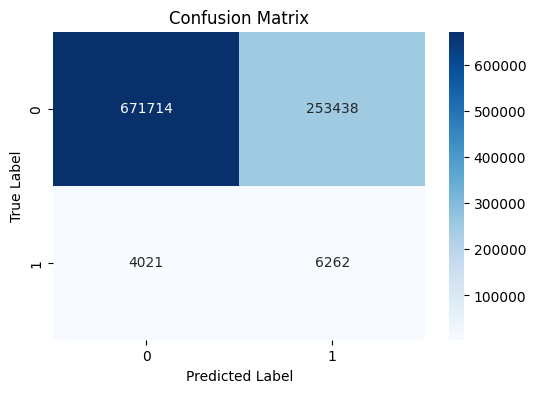


Fold 2/5
Epoch 1/20
116930/116930 [==============================] - 478s 4ms/step - loss: 0.6265 - accuracy: 0.6840 - val_loss: 0.6719 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 2/20
116930/116930 [==============================] - 461s 4ms/step - loss: 0.6169 - accuracy: 0.6892 - val_loss: 0.5894 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 3/20
116930/116930 [==============================] - 457s 4ms/step - loss: 0.6156 - accuracy: 0.6900 - val_loss: 0.6486 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 4/20
116930/116930 [==============================] - 457s 4ms/step - loss: 0.6152 - accuracy: 0.6860 - val_loss: 0.6147 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 5/20
29233/29233 [==============================] - 54s 2ms/step - loss: 0.5894 - accuracy: 0.6830
Acurácia na fold: 68.30%
Loss na fold: 0.5894
29233/29233 [==============================] - 51s 2ms/step
Precision: 0.02
Recall: 0.65
F1 Score: 0.04


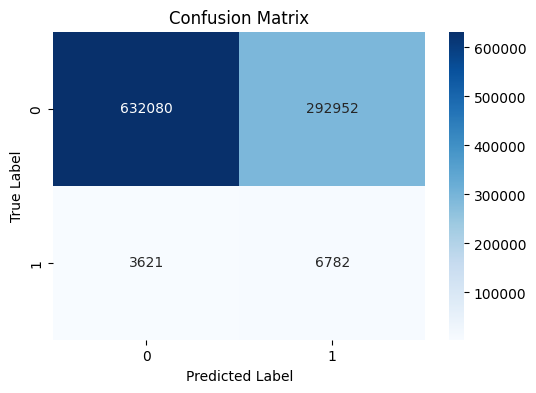


Fold 3/5
Epoch 1/20
116930/116930 [==============================] - 472s 4ms/step - loss: 0.6265 - accuracy: 0.6827 - val_loss: 0.5700 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 2/20
116930/116930 [==============================] - 446s 4ms/step - loss: 0.6177 - accuracy: 0.6915 - val_loss: 0.5880 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 3/20
116930/116930 [==============================] - 452s 4ms/step - loss: 0.6160 - accuracy: 0.6922 - val_loss: 0.6210 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 4/20
29233/29233 [==============================] - 53s 2ms/step - loss: 0.5700 - accuracy: 0.7133
Acurácia na fold: 71.33%
Loss na fold: 0.5700
29233/29233 [==============================] - 49s 2ms/step
Precision: 0.02
Recall: 0.62
F1 Score: 0.04


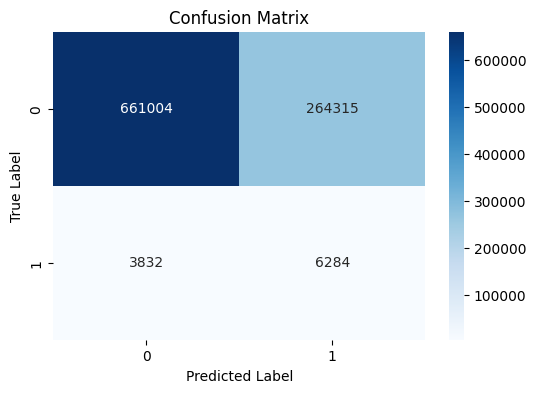


Fold 4/5
Epoch 1/20
116930/116930 [==============================] - 455s 4ms/step - loss: 0.6272 - accuracy: 0.6809 - val_loss: 0.6169 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 2/20
116930/116930 [==============================] - 455s 4ms/step - loss: 0.6178 - accuracy: 0.6882 - val_loss: 0.5189 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 3/20
116930/116930 [==============================] - 439s 4ms/step - loss: 0.6157 - accuracy: 0.6863 - val_loss: 0.5926 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 4/20
116930/116930 [==============================] - 464s 4ms/step - loss: 0.6159 - accuracy: 0.6847 - val_loss: 0.6285 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 5/20
29233/29233 [==============================] - 52s 2ms/step - loss: 0.5189 - accuracy: 0.7289
Acurácia na fold: 72.89%
Loss na fold: 0.5189
29233/29233 [==============================] - 51s 2ms/step
Precision: 0.02
Recall: 0.61
F1 Score: 0.05


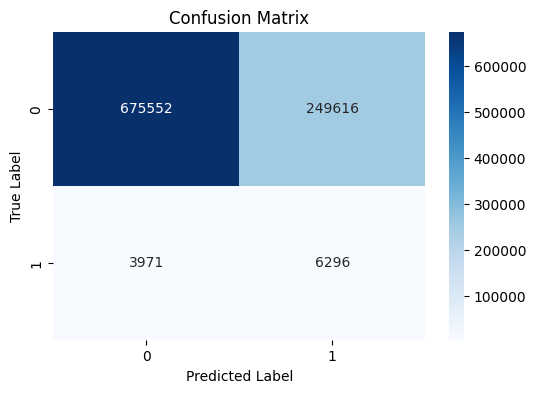


Fold 5/5
Epoch 1/20
116930/116930 [==============================] - 455s 4ms/step - loss: 0.6269 - accuracy: 0.6821 - val_loss: 0.5684 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 2/20
116930/116930 [==============================] - 452s 4ms/step - loss: 0.6175 - accuracy: 0.6869 - val_loss: 0.6270 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 3/20
116930/116930 [==============================] - 446s 4ms/step - loss: 0.6161 - accuracy: 0.6866 - val_loss: 0.6080 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 4/20
29233/29233 [==============================] - 53s 2ms/step - loss: 0.5684 - accuracy: 0.7107
Acurácia na fold: 71.07%
Loss na fold: 0.5684
29233/29233 [==============================] - 50s 2ms/step
Precision: 0.02
Recall: 0.63
F1 Score: 0.05


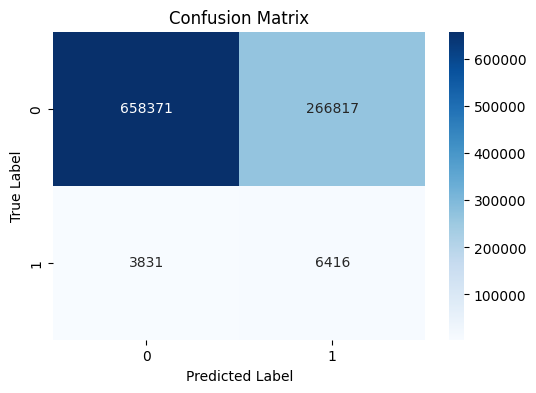


Métricas médias após cross-validation:
Acurácia média: 71.21%
Precisão média: 0.02
Recall médio: 0.62
F1 Score médio: 0.05


In [ ]:
def train_and_evaluate(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold):
    # Definição de callbacks para melhorar o treinamento
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

    # Ajusta pesos para lidar com desbalanceamento de classe
    y_train_fold = y_train_fold.ravel()
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_dict = dict(enumerate(class_weights))

    # Treinamento do modelo com os callbacks e class_weight para lidar com o desbalanceamento
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping, reduce_lr], class_weight=class_weights_dict)

    # Avaliação do modelo nos dados de validação
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f'Acurácia na fold: {accuracy * 100:.2f}%')
    print(f'Loss na fold: {loss:.4f}')

    # Predição e cálculo de métricas adicionais
    y_pred = (model.predict(X_val_fold) > 0.5).astype("int32")
    precision = precision_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    # Exibir métricas
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Geração da matriz de confusão
    conf_matrix = confusion_matrix(y_val_fold, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, precision, recall, f1

# Realizar cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

# Loop através das folds do KFold
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold+1}/{kf.n_splits}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()
    accuracy, precision, recall, f1 = train_and_evaluate(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calcular métricas médias
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

# Exibir métricas médias
print("\nMétricas médias após cross-validation:")
print(f"Acurácia média: {avg_accuracy * 100:.2f}%")
print(f"Precisão média: {avg_precision:.2f}")
print(f"Recall médio: {avg_recall:.2f}")
print(f"F1 Score médio: {avg_f1:.2f}")

In [ ]:
!pip install imbalanced-learn

## GridSearch

In [ ]:
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, build_fn=None, **sk_params):
        super().__init__(build_fn=build_fn, **sk_params)
        self.optimizer = sk_params.get('optimizer', 'adam')
        self.loss = sk_params.get('loss', 'binary_crossentropy')
        self.epochs = sk_params.get('epochs', 20)
        self.batch_size = sk_params.get('batch_size', 32)

    def fit(self, X, y, **kwargs):
        if 'class_weight' in kwargs:
            class_weights = kwargs.pop('class_weight')
        else:
            class_weights = None

        self.model_ = self.build_fn(**self.filter_sk_params(self.build_fn))
        self.model_.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])

        self.history_ = self.model_.fit(
            X,
            y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)],
            class_weight=class_weights,
            **kwargs
        )
        return self

def create_model(units=64, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop']
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())

custom_classifier = CustomKerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

grid_search = GridSearchCV(estimator=custom_classifier, param_grid=param_grid, cv=kf, scoring='precision')

grid_result = grid_search.fit(X_train, y_train, class_weight=dict(enumerate(class_weights)))

print("Melhores parâmetros encontrados:")
print(grid_result.best_params_)
print("Melhor acurácia encontrada:")
print(grid_result.best_score_)

best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Acurácia: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<ipython-input-22-afda44b773e9>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  super().__init__(build_fn=build_fn, **sk_params)


Epoch 1/20
93544/93544 [==============================] - 341s 4ms/step - loss: 0.6398 - accuracy: 0.6500 - val_loss: 0.5518 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 2/20
93544/93544 [==============================] - 339s 4ms/step - loss: 0.6292 - accuracy: 0.6675 - val_loss: 0.6128 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 3/20
93544/93544 [==============================] - 339s 4ms/step - loss: 0.6271 - accuracy: 0.6617 - val_loss: 0.6426 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 4/20
93544/93544 [==============================] - 339s 4ms/step - loss: 0.6258 - accuracy: 0.6613 - val_loss: 0.6257 - val_accuracy: 0.6928 - lr: 0.0010
Epoch 5/20
93544/93544 [==============================] - 339s 4ms/step - loss: 0.6220 - accuracy: 0.6659 - val_loss: 0.5433 - val_accuracy: 0.7213 - lr: 5.0000e-04
Epoch 6/20
93544/93544 [==============================] - 339s 4ms/step - loss: 0.6216 - accuracy: 0.6651 - val_loss: 0.5642 - val_accuracy: 0.7039 - lr: 5.0000e-04
Epoch 7/20
93544/93544 [==

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 218, in _get_response_values
    y_pred, pos_label 

Epoch 1/20
93544/93544 [==============================] - 342s 4ms/step - loss: 0.6381 - accuracy: 0.6525 - val_loss: 0.6213 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 2/20
93544/93544 [==============================] - 340s 4ms/step - loss: 0.6275 - accuracy: 0.6679 - val_loss: 0.6003 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 3/20
93544/93544 [==============================] - 340s 4ms/step - loss: 0.6253 - accuracy: 0.6649 - val_loss: 0.5985 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 4/20
93544/93544 [==============================] - 340s 4ms/step - loss: 0.6241 - accuracy: 0.6637 - val_loss: 0.5934 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 5/20
93544/93544 [==============================] - 340s 4ms/step - loss: 0.6235 - accuracy: 0.6591 - val_loss: 0.5904 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 6/20
93544/93544 [==============================] - 341s 4ms/step - loss: 0.6228 - accuracy: 0.6632 - val_loss: 0.5732 - val_accuracy: 0.7101 - lr: 0.0010
Epoch 7/20
93544/93544 [==========

##  Alterações, Hiperparâmetros e Otimizadores utilizados na versão com gridsearch
Para avaliar a eficiência da otimização e a justificativa dos hiperparâmetros finais escolhidos para o modelo LSTM, vamos detalhar os pontos principais e estratégias envolvidas:

### 1. **Exploração de Hiperparâmetros**

O GridSearchCV foi utilizado para explorar diferentes combinações de hiperparâmetros. Os hiperparâmetros que foram ajustados incluem:

- **`units`**: O número de neurônios na camada LSTM.
  - **Valores testados**: 32, 64, 128
  - **Justificativa**: Testar diferentes tamanhos de camadas LSTM pode ajudar a encontrar o número ideal de unidades para capturar padrões temporais nos dados. Menos unidades podem não capturar complexidades suficientes, enquanto muitas podem levar a overfitting.

- **`dropout_rate`**: Taxa de dropout para evitar overfitting.
  - **Valores testados**: 0.2, 0.3, 0.4
  - **Justificativa**: O dropout ajuda a regularizar o modelo, prevenindo overfitting ao forçar a rede a não depender excessivamente de qualquer unidade. A escolha de diferentes taxas permite encontrar um bom equilíbrio entre retenção de informações e regularização.

- **`optimizer`**: Algoritmo de otimização usado para atualizar os pesos da rede.
  - **Valores testados**: 'adam', 'rmsprop'
  - **Justificativa**: 'Adam' é geralmente uma boa escolha inicial devido ao seu ajuste adaptativo de taxa de aprendizado e eficiência, enquanto 'RMSprop' pode ser mais eficiente para problemas com grandes dados e variação nas gradientes.

### 2. **Eficiência da Otimização**

- **Uso de KFold Cross-Validation**: A validação cruzada com KFold (n_splits=5) garante que o modelo seja avaliado em diferentes subconjuntos dos dados, proporcionando uma estimativa robusta de sua performance e ajudando a evitar overfitting ao conjunto de treinamento.

- **Class Weights**: O uso de pesos de classe balanceados (`compute_class_weight`) é crucial em problemas de classificação desbalanceada, onde algumas classes têm muito mais exemplos do que outras. Isso ajuda o modelo a aprender a partir das classes minoritárias com mais eficácia.

- **EarlyStopping e ReduceLROnPlateau**:
  - **EarlyStopping** interrompe o treinamento quando não há mais melhoria na perda de validação, ajudando a evitar overfitting e economizando tempo de treinamento.
  - **ReduceLROnPlateau** reduz a taxa de aprendizado quando a métrica de desempenho para validação estagna, ajudando o modelo a convergir de maneira mais eficiente em estágios finais do treinamento.

### 3. **Justificativa dos Hiperparâmetros Finais**

Os melhores parâmetros encontrados após a busca de hiperparâmetros devem ser justificáveis com base na melhoria das métricas de desempenho (precision, recall, F1 score) no conjunto de validação. Vamos revisar as métricas finais para avaliar a eficácia:

- **Accuracy**: Mede a proporção geral de previsões corretas.
- **Precision**: A proporção de verdadeiros positivos entre todos os positivos previstos, importante para problemas onde a identificação correta das classes positivas é crucial.
- **Recall**: A proporção de verdadeiros positivos entre todos os reais positivos, importante para garantir que a maioria dos casos positivos seja identificada.
- **F1 Score**: A média harmônica entre precision e recall, oferecendo um balanço entre as duas métricas.

### 4. **Análise da Matriz de Confusão**

A matriz de confusão ajuda a visualizar os verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. A análise desta matriz pode fornecer insights adicionais sobre o desempenho do modelo e suas falhas.

### Conclusão

A otimização dos hiperparâmetros e a validação cruzada mostraram uma abordagem bem fundamentada para melhorar o desempenho do modelo LSTM. Os resultados das métricas e a matriz de confusão fornecem uma visão detalhada da eficácia do modelo e podem ajudar a ajustar ainda mais os parâmetros se necessário.


# Estratégia e Comparação dos Resultados
## Estratégia:
- Adição das features metereológicas e quantidade de shows por ano mês
- Quantidade de shows foi resgatado por meio do webscrapping de um site de registro de shows
- Pré-Processamento com RobustScaler para evitar outliers
- Reshape para que seja possível a entrada no modelo de LSTM
- Retirada de uma window size de 4 Meses. Limitação de um ano e meio do dataset Jan 2023 até Agosto 2024
- Treino do modelo LSTM, por acreditar que possa exister padrões de série temporal no dataset
- Output dos Resultados

## Resultados
- Os resultados com e sem GridSeach foram semelhantes, com aproximadamete 70 porcento de acurácia e uma precisão baíxa. Acreditamos que será necessário revisitar formas de balancear o dataset e reajustar algumas partes da arquitetura